# Machine Learning

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Load data
tokens = pd.read_parquet('tokens.gzip')

In [3]:
# create data
tokens_only = tokens.drop(['close2017','close2018','close2019','close2020','close2021'], axis = 1)
profit_2018 = (tokens['close2018'] - tokens['close2017']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")
profit_2019 = (tokens['close2019'] - tokens['close2018']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")
profit_2020 = (tokens['close2020'] - tokens['close2019']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")

tokens_2019 = tokens_only.join(profit_2018)
tokens_2020 = tokens_only.join(profit_2019)

tokens_2020.head()

,type,num_attrs,attribute0,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,lastprofit
0,Female,3,Blonde Bob,Earring,Green Eye Shadow,,,,,nil
1,Male,2,Mohawk,Smile,,,,,,profit
2,Female,1,Wild Hair,,,,,,,nil
3,Male,3,Nerd Glasses,Pipe,Wild Hair,,,,,nil
4,Male,4,Big Shades,Earring,Goat,Wild Hair,,,,nil


In [4]:
# setup columns
num_col_selector = make_column_selector(dtype_exclude=object)
cat_col_selector = make_column_selector(dtype_include=object)

num_cols = num_col_selector(tokens_2020)
cat_cols = cat_col_selector(tokens_2020)

# preprocess columns
cat_preproc = OneHotEncoder(handle_unknown="ignore")
num_preproc = StandardScaler()

# create preprocessing pipeline
preproc = ColumnTransformer([
    ('one-hot-encoder', cat_preproc, cat_cols),
    ('standard_scaler', num_preproc, num_cols)])

# Expt1

The mean cross-validation accuracy is: 0.621 +/- 0.024
model score: 0.6378


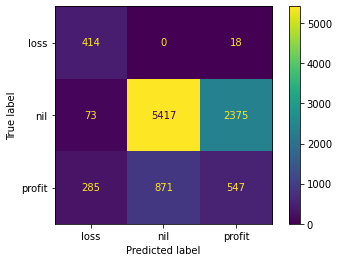

In [5]:
# create logistic regression pipeline
model = make_pipeline(preproc, LogisticRegression(max_iter=500, class_weight = 'balanced'))

# cross-validation
cv = cross_validate(model, tokens_2020, profit_2020, cv = 5)
scores = cv["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

# fit the model to 2019 data
model.fit(tokens_2019, profit_2019)

# score the model on 2020 data
print(f"model score: {model.score(tokens_2020, profit_2020)}")

# confusion matrix
ConfusionMatrixDisplay.from_estimator(model, tokens_2020, profit_2020)

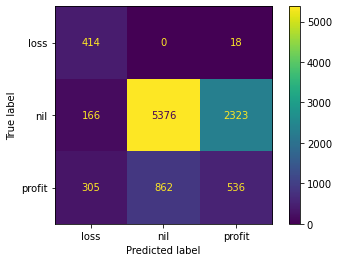

In [6]:
threshold = 0.5
out = []
for i in model.predict_proba(tokens_2020):
    if i[2] > threshold:
        out.append("profit")
    elif i[1] > threshold:
        out.append("nil")
    else:
        out.append("loss")
profit_2020_pred = np.array(out).astype(object)

ConfusionMatrixDisplay.from_predictions(profit_2020, profit_2020_pred)

# Expt 2

The mean cross-validation accuracy is: 0.810 +/- 0.007
model score: 0.8126


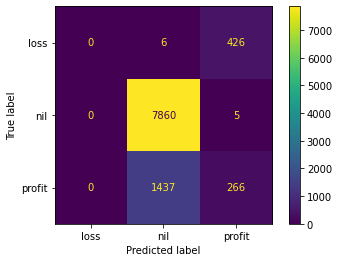

In [7]:
# create logistic regression pipeline
model = make_pipeline(preproc,
                      GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0))

# cross-validation
cv = cross_validate(model, tokens_2020, profit_2020, cv = 5)
scores = cv["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

# fit the model to 2019 data
model.fit(tokens_2019, profit_2019)

# score the model on 2020 data
print(f"model score: {model.score(tokens_2020, profit_2020)}")

# confusion matrix
ConfusionMatrixDisplay.from_estimator(model, tokens_2020, profit_2020)

<AxesSubplot:>

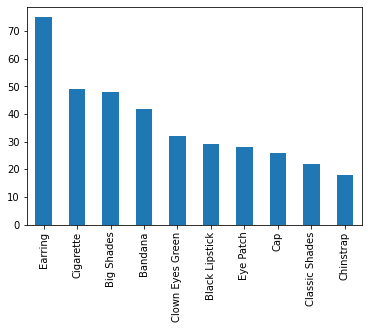

In [8]:
# visualization
profit_2020_pred = model.predict(tokens_2020)
tokens_2020_pred_profit = tokens_2020[profit_2020_pred == 'profit']

tokens_2020_pred_profit['attribute0'].value_counts()[:10].plot.bar()

<AxesSubplot:>

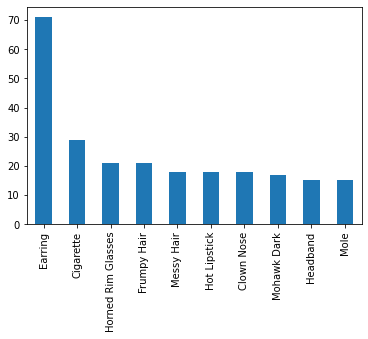

In [9]:
tokens_2020_pred_profit['attribute1'].value_counts()[:10].plot.bar()

<AxesSubplot:>

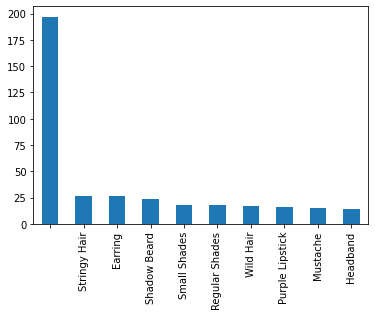

In [10]:
tokens_2020_pred_profit['attribute2'].value_counts()[:10].plot.bar()